In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.legend_handler import HandlerLine2D
from sklearn.metrics import r2_score

In [2]:
"""Inputting the training and the test dataset"""
# Point to note - No need for data normalization as such for Random forrest regressor
Training_set = pd.read_csv('./train.csv', index_col = 'Id')
Testing_set = pd.read_csv('./test.csv', index_col = 'Id')
#IDs of testing set
Testing_set_IDs = list(Testing_set.index)

Y_train = Training_set['SalePrice']
del Training_set['SalePrice']

In [3]:
"""Replacing nans with zeros"""
Training_set = Training_set.fillna(0)
Testing_set = Testing_set.fillna(0)

In [4]:
"""Reordering columns"""
Coltype_dict = pd.DataFrame(Training_set.dtypes)
Coltype_dict.reset_index(inplace = True)
Coltype_dict = Coltype_dict.rename(columns={0:"Datatype", "index":"Colname"})
Coltype_dict["Datatype"]= Coltype_dict["Datatype"].astype(str) 
Coltype_dict = dict(zip(Coltype_dict['Colname'],Coltype_dict['Datatype']))

In [5]:
Numerical_cols = [k for k,v in Coltype_dict.items() if (v == 'int64' or v == 'float64')]
NonNumer_cols = [k for k,v in Coltype_dict.items() if v == 'object']
Rearngd_cols = Numerical_cols + NonNumer_cols

Training_set = Training_set.reindex(columns=Rearngd_cols)
Testing_set = Testing_set.reindex(columns=Rearngd_cols)

In [6]:
"""Using Label encoder to transform string cols"""
LE = preprocessing.LabelEncoder()

# Encoding training data
Strcols_Train = Training_set.loc[:, 'MSZoning':]
Strcols_Train = Strcols_Train.astype(str)
Strcols_Train = Strcols_Train.apply(LE.fit_transform)
Training_set = pd.concat([Training_set.loc[:, :'YrSold'], Strcols_Train], axis=1)

# Encoding testing data 
Strcols_Test = Testing_set.loc[:, 'MSZoning':]
Strcols_Test = Strcols_Test.astype(str)
Strcols_Test = Strcols_Test.apply(LE.fit_transform)
Testing_set = pd.concat([Testing_set.loc[:, :'YrSold'], Strcols_Test], axis=1)

In [7]:
""" Generating correlation of Saleprice with other features""" 
CorSaleprice = pd.concat([Training_set, pd.DataFrame(Y_train)], axis=1)
CorSaleprice = CorSaleprice.corr()
CorSaleprice = pd.DataFrame(CorSaleprice['SalePrice'].sort_values(ascending=False)[1:])

In [8]:
CorSaleprice.T

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,...,MSZoning,Fence,BsmtExposure,GarageType,LotShape,GarageFinish,HeatingQC,BsmtQual,KitchenQual,ExterQual
SalePrice,0.790982,0.708624,0.640409,0.623431,0.613581,0.605852,0.560664,0.533723,0.522897,0.507101,...,-0.166872,-0.181911,-0.193079,-0.223819,-0.25558,-0.292483,-0.400178,-0.438881,-0.589189,-0.636884


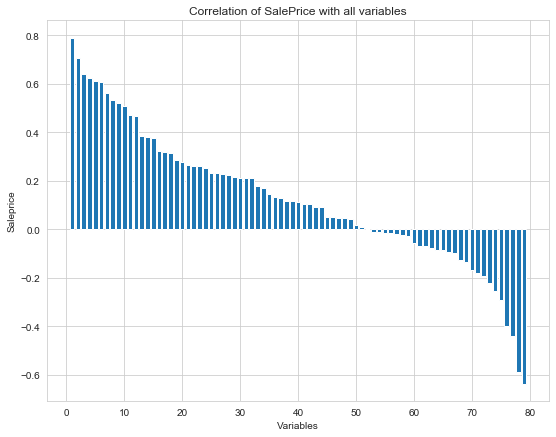

In [44]:
"""Correlation plots"""
fig, ax = plt.subplots(figsize=(9, 7))
ax.bar(x = range(1,len(CorSaleprice)+1), height = CorSaleprice['SalePrice'])
plt.ylabel('Saleprice')
plt.xlabel('Variables')
plt.title('Correlation of SalePrice with all variables')
plt.show()

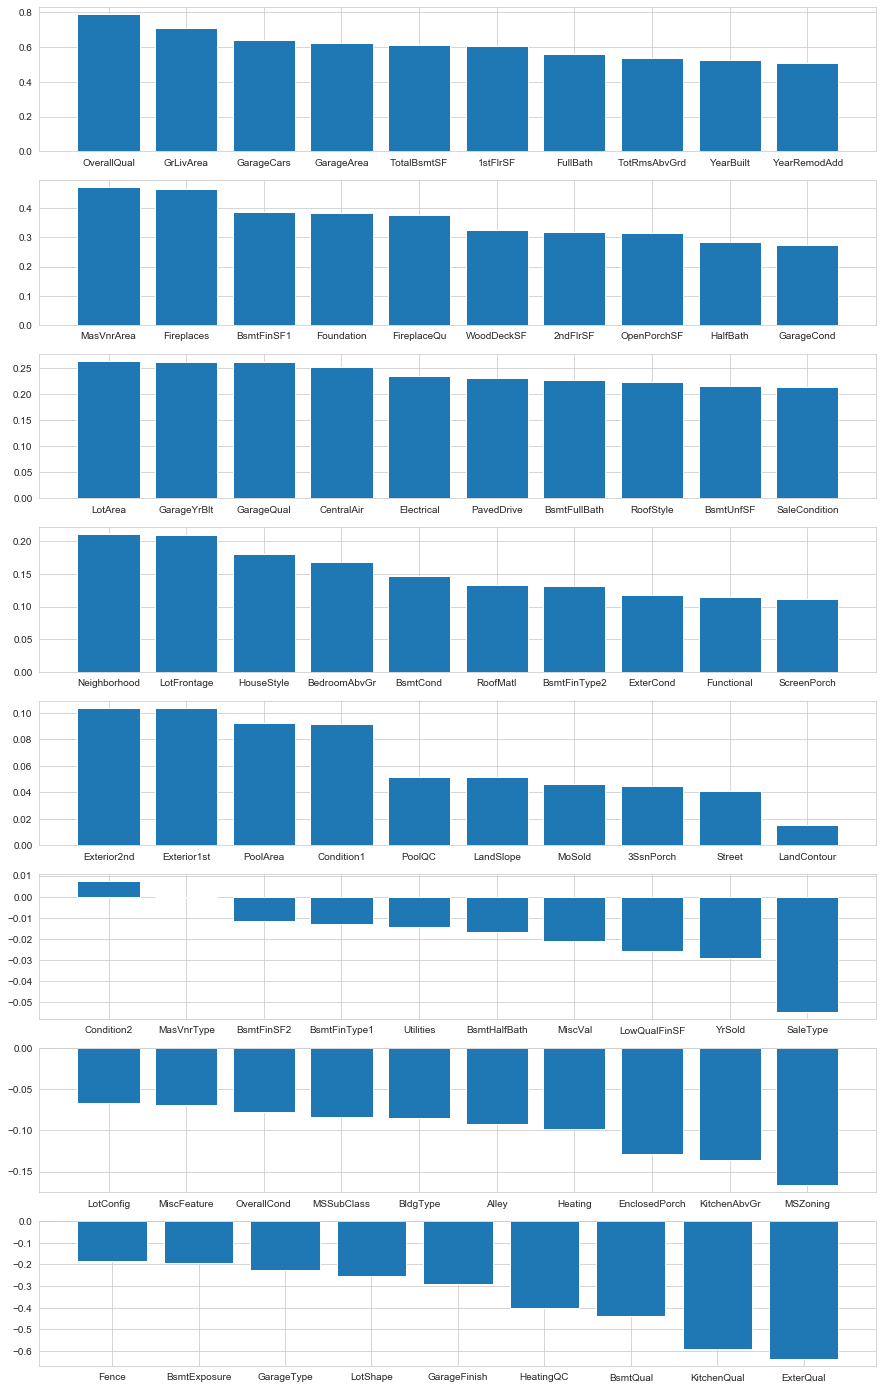

In [45]:
"""Correlation plots zoomed"""
fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8)) = plt.subplots(8, figsize=(15, 25))
#fig.suptitle('Correlation of SalePrice with all variables')
ax1.bar(x = CorSaleprice.index[0:10], height = CorSaleprice['SalePrice'][0:10])
ax2.bar(x = CorSaleprice.index[10:20], height = CorSaleprice['SalePrice'][10:20])
ax3.bar(x = CorSaleprice.index[20:30], height = CorSaleprice['SalePrice'][20:30])
ax4.bar(x = CorSaleprice.index[30:40], height = CorSaleprice['SalePrice'][30:40])
ax5.bar(x = CorSaleprice.index[40:50], height = CorSaleprice['SalePrice'][40:50])
ax6.bar(x = CorSaleprice.index[50:60], height = CorSaleprice['SalePrice'][50:60])
ax7.bar(x = CorSaleprice.index[60:70], height = CorSaleprice['SalePrice'][60:70])
ax8.bar(x = CorSaleprice.index[70:80], height = CorSaleprice['SalePrice'][70:80])
plt.show()

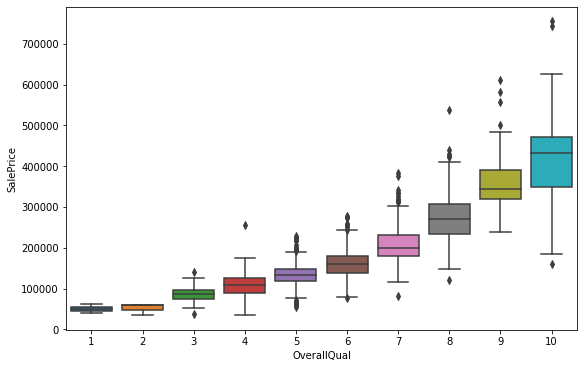

In [11]:
# Scatter plot of Price with Overall Quality
fig = plt.figure(constrained_layout=True, figsize=(8,5))
sns.boxplot(Training_set['OverallQual'], Y_train)
plt.show()

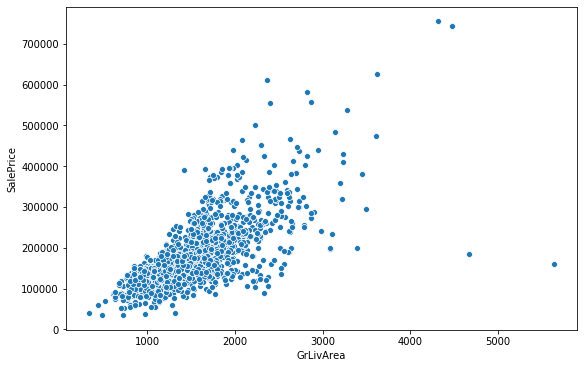

In [12]:
# Scatter plot of Price with 'GrLivArea: Above grade (ground) living area square feet'
fig = plt.figure(constrained_layout=True, figsize=(8,5))
sns.scatterplot(Training_set['GrLivArea'], Y_train)
plt.show()

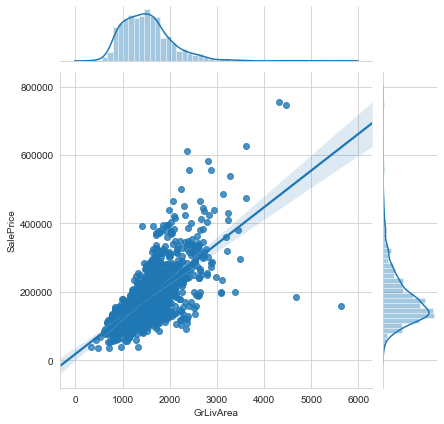

In [13]:
sns.set_style('whitegrid')
sns.jointplot(Training_set['GrLivArea'], Y_train, kind = 'reg')

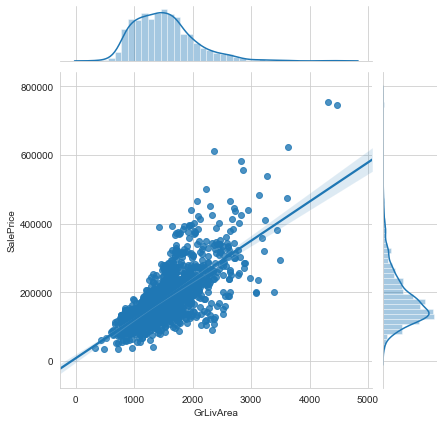

In [31]:
# Removing the two outliers corresponding to GrLivArea dataset
Training_set['SalePrice'] = Y_train
Training_set = Training_set.drop(Training_set[(Training_set['GrLivArea']>4000) & (Training_set['SalePrice']<200000)].index)
Y_train = Training_set['SalePrice']
del Training_set['SalePrice']

sns.set_style('whitegrid')
sns.jointplot(Training_set['GrLivArea'], Y_train, kind = 'reg')

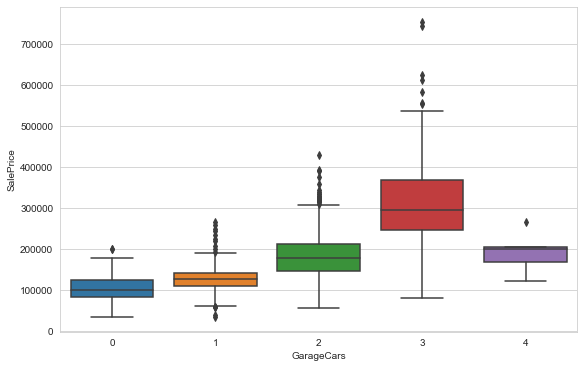

In [15]:
# Scatter plot of Price with 'GarageCars: Size of garage in car capacity'
fig = plt.figure(constrained_layout=True, figsize=(8,5))
sns.boxplot(Training_set['GarageCars'], Y_train)
plt.show()

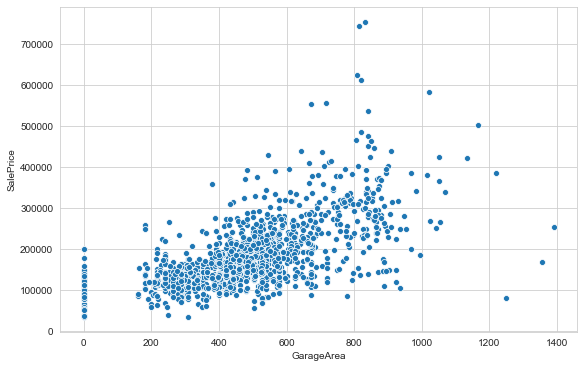

In [16]:
# Scatter plot of Price with 'GarageArea: Size of garage in square feet'
fig = plt.figure(constrained_layout=True, figsize=(8,5))
sns.scatterplot(Training_set['GarageArea'], Y_train)
plt.show()

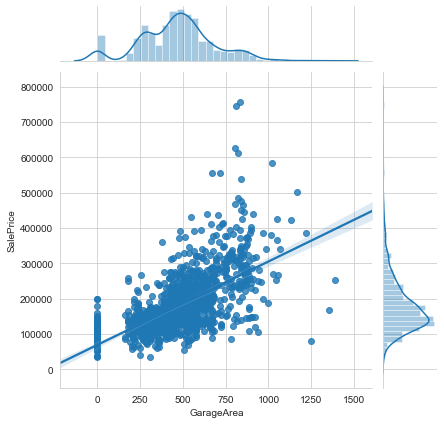

In [17]:
sns.set_style('whitegrid')
sns.jointplot(Training_set['GarageArea'], Y_train, kind = 'reg')

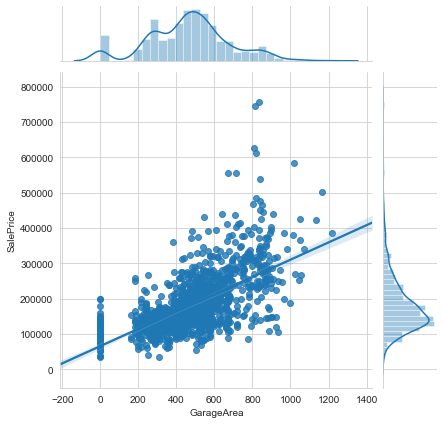

In [18]:
# Removing Outliers
Training_set['SalePrice'] = Y_train
Training_set = Training_set.drop(Training_set[(Training_set['GarageArea']>1200) & (Training_set['SalePrice']<300000)].index)
Y_train = Training_set['SalePrice']
del Training_set['SalePrice']

sns.set_style('whitegrid')
sns.jointplot(Training_set['GarageArea'], Y_train, kind = 'reg')

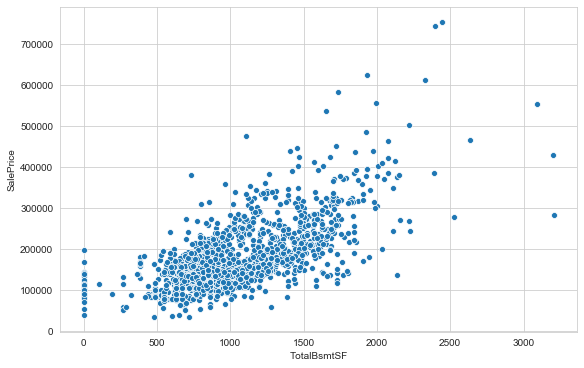

In [19]:
# Scatter plot of Price with 'TotalBsmtSF: Total square feet of basement area'
fig = plt.figure(constrained_layout=True, figsize=(8,5))
sns.scatterplot(Training_set['TotalBsmtSF'], Y_train)
plt.show()

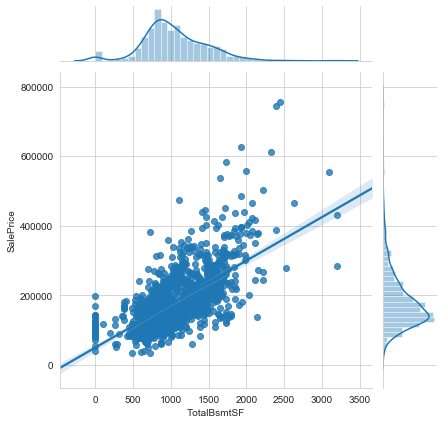

In [20]:
sns.set_style('whitegrid')
sns.jointplot(Training_set['TotalBsmtSF'], Y_train, kind = 'reg')

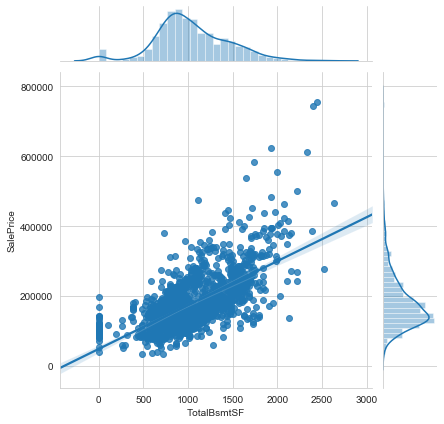

In [21]:
# Removing Outliers 
Training_set['SalePrice'] = Y_train
Training_set = Training_set.drop(Training_set[(Training_set['TotalBsmtSF']>3000) & (Training_set['SalePrice']<600000)].index)
Y_train = Training_set['SalePrice']
del Training_set['SalePrice']

sns.set_style('whitegrid')
sns.jointplot(Training_set['TotalBsmtSF'], Y_train, kind = 'reg')

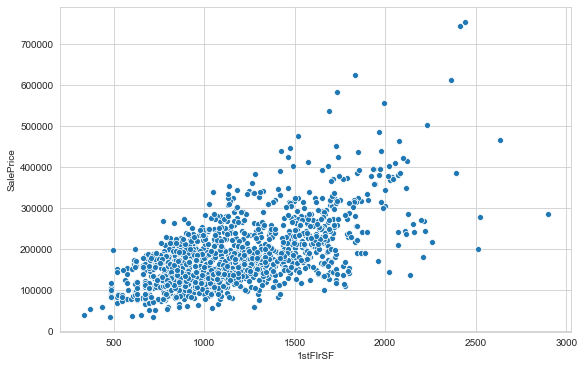

In [22]:
# Scatter plot of Price with '1stFlrSF: First Floor square feet'
fig = plt.figure(constrained_layout=True, figsize=(8,5))
sns.scatterplot(Training_set['1stFlrSF'], Y_train)
plt.show()

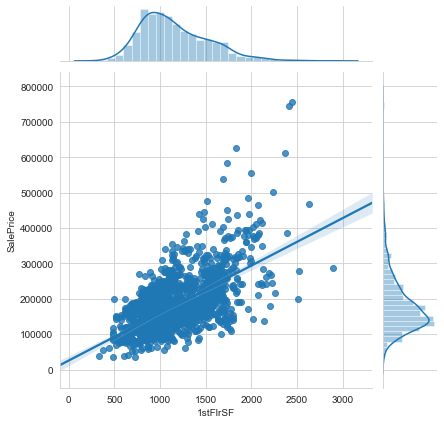

In [32]:
sns.set_style('whitegrid')
sns.jointplot(Training_set['1stFlrSF'], Y_train, kind = 'reg')

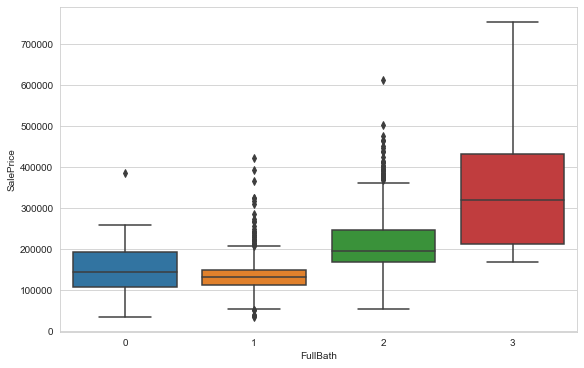

In [24]:
# Scatter plot of Price with 'FullBath: Full bathrooms above grade'
fig = plt.figure(constrained_layout=True, figsize=(8,5))
sns.boxplot(Training_set['FullBath'], Y_train)
plt.show()

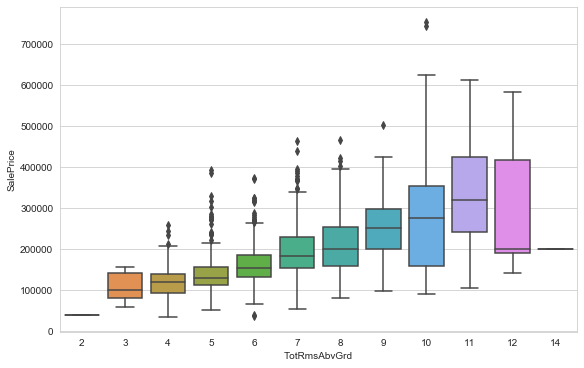

In [25]:
# Scatter plot of Price with 'TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)'
fig = plt.figure(constrained_layout=True, figsize=(8,5))
sns.boxplot(Training_set['TotRmsAbvGrd'], Y_train)
plt.show()

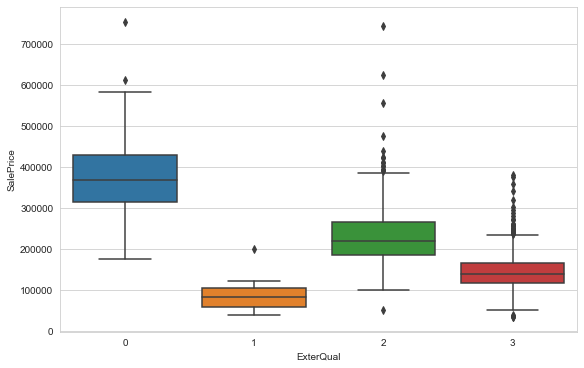

In [26]:
# Scatter plot of Price with 'ExterQual: Evaluates the quality of the material on the exterior'
fig = plt.figure(constrained_layout=True, figsize=(8,5))
sns.boxplot(Training_set['ExterQual'], Y_train)
plt.show()

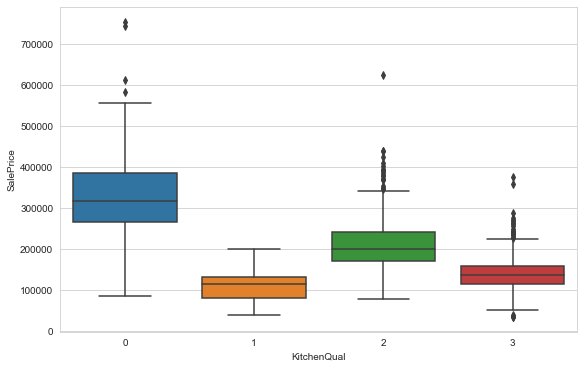

In [27]:
# Scatter plot of Price with 'KitchenQual: Kitchen quality'
fig = plt.figure(constrained_layout=True, figsize=(8,5))
sns.boxplot(Training_set['KitchenQual'], Y_train)
plt.show()

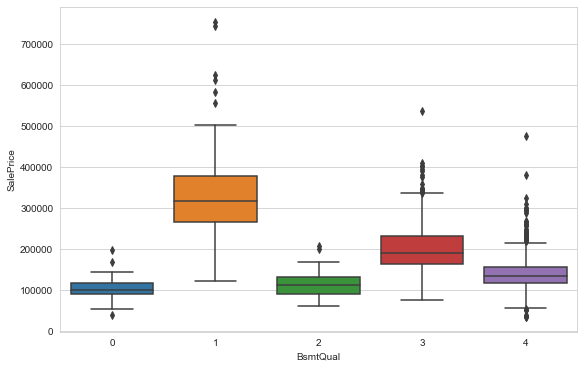

In [28]:
# Scatter plot of Price with 'BsmtQual: Basement quality'
fig = plt.figure(constrained_layout=True, figsize=(8,5))
sns.boxplot(Training_set['BsmtQual'], Y_train)
plt.show()

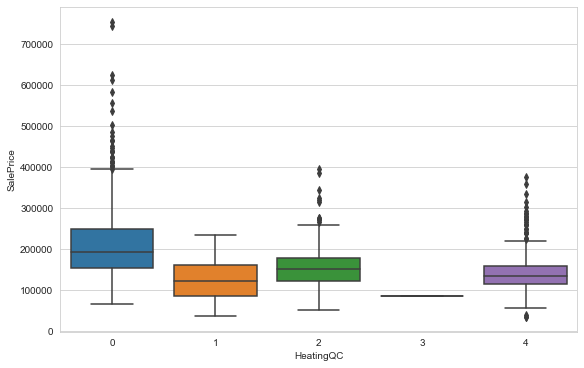

In [29]:
# Scatter plot of Price with 'HeatingQC: Heating quality and Condition'
fig = plt.figure(constrained_layout=True, figsize=(8,5))
sns.boxplot(Training_set['HeatingQC'], Y_train)
plt.show()

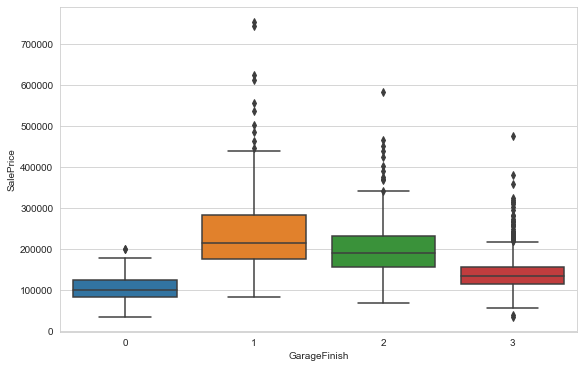

In [30]:
# Scatter plot of Price with 'GarageFinish'
fig = plt.figure(constrained_layout=True, figsize=(8,5))
sns.boxplot(Training_set['GarageFinish'], Y_train)
plt.show()

In [ ]:
"""Implementing Random forest"""
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

RandomForest_Tuned = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid, n_iter = 100, cv = 7, verbose=2, random_state=42, n_jobs = -1)
RandomForest_Tuned.fit(Training_set, Y_train)
print(RandomForest_Tuned.best_estimator_)

# Predicting
Y_test = RandomForest_Tuned.predict(Testing_set)

In [34]:
# Outputfile
Outputfile = pd.DataFrame(Y_test, Testing_set.index)
Outputfile.reset_index(inplace = True)
Outputfile = Outputfile.rename(columns={0:"SalePrice"})
Outputfile.to_csv('Outputfile_Amulye.csv', index = False)

In [40]:
# Training set predicted values
Y_train_pred = RandomForest_Tuned.predict(Training_set)

In [41]:
# Training set R-squarred (In sample R squarred)
Insample_r2 = r2_score(Y_train, Y_train_pred)
print(Insample_r2)

0.9966239082996405


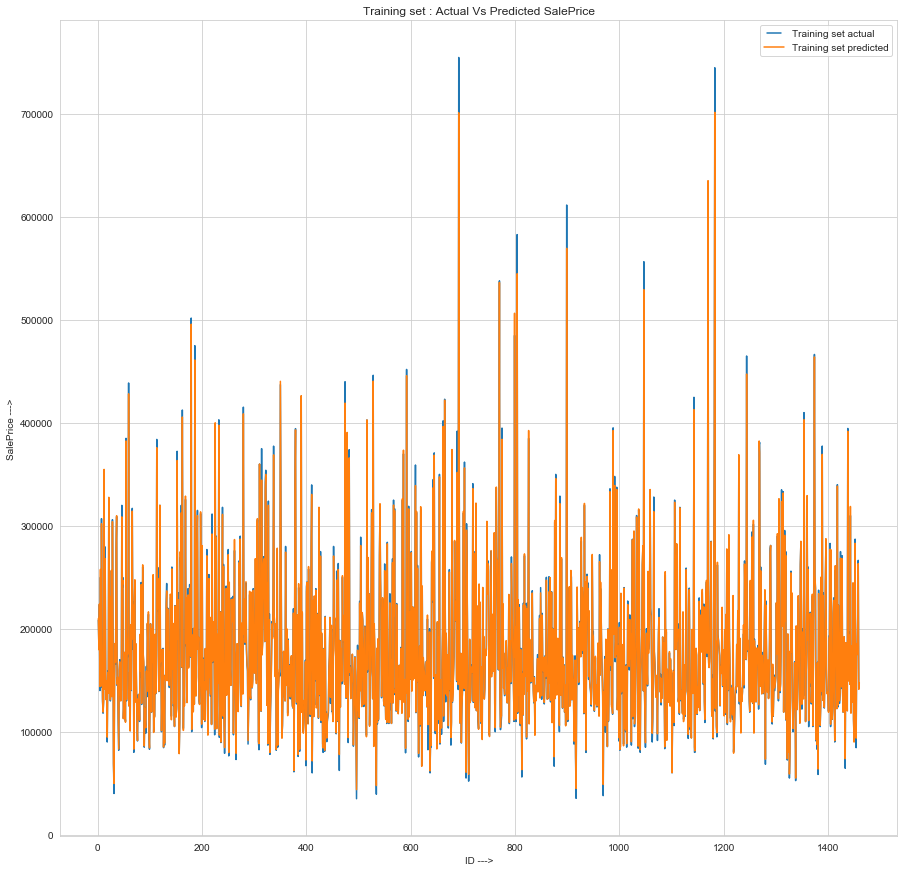

In [42]:
# Plotting the actual training set values w.r.t Predicted training set values
plt.figure(figsize=(15, 15))
line1, = plt.plot(Y_train.index, Y_train, label = 'Training set actual')
line2, = plt.plot(Y_train.index, Y_train_pred, label = 'Training set predicted')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.title('Training set : Actual Vs Predicted SalePrice')
plt.ylabel('SalePrice --->')
plt.xlabel('ID --->')
plt.show()

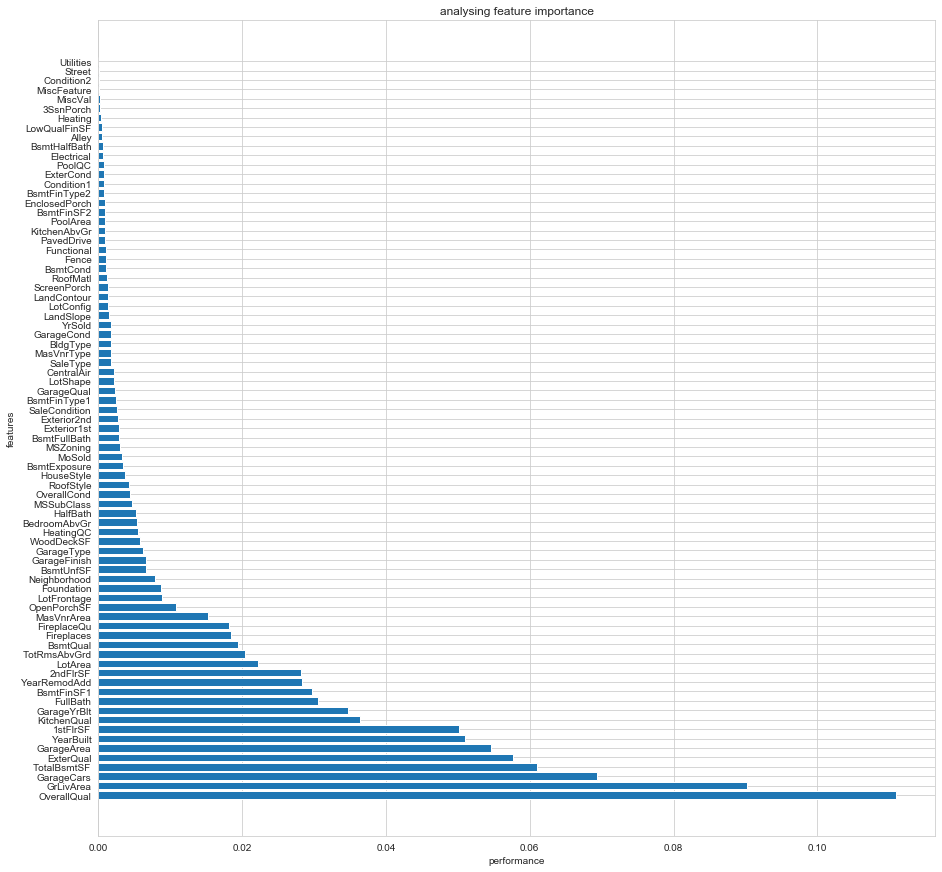

In [43]:
# Feature Importance for Random Forrest

model = RandomForest_Tuned.best_estimator_
importance = model.feature_importances_

importance_dict = {Testing_set.columns[i]:importance[i] for i in range(len(importance))}

import operator
importance_dict = dict(sorted(importance_dict.items(), key=operator.itemgetter(1),reverse=True))

# plotting feature importance
plt.figure(figsize=(15, 15))
plt.barh(list(importance_dict.keys()), list(importance_dict.values()))
plt.xlabel('performance')
plt.ylabel('features')
plt.title('analysing feature importance')
plt.show()